If you're working off of your local machine and the following doesn't say the active environment is `DropPinchoff` something may have gone wrong with the setup.  You can still use this notebook, but you'll have to install opencv and ipympl manually.  You can do that by un-commenting the two cells following `!conda info`

In [1]:
!conda info


     active environment : DropPinchoff
    active env location : /opt/anaconda3/envs/DropPinchoff
            shell level : 2
       user config file : /Users/kevin 1/.condarc
 populated config files : /Users/kevin 1/.condarc
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __osx=10.16=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/anaconda3  (writable)
      conda av data dir : /opt/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/osx-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/no

In [2]:
#pip install opencv-python

In [3]:
#pip install ipympl

In [4]:
# Import the libraries
%matplotlib widget

import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import logging as log
logger = log.getLogger()
logger.setLevel(log.CRITICAL) # set to log.DEBUG to get debugging info
#logger.setLevel(log.DEBUG)
log.debug("Debugger initialized")

In [5]:
max_length = 200  
    # Defines the number of frames to read over

In [6]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

fname = "Drop.mp4"

try:
    with open(fname):
        pass
except:
    print("File not found.  Make sure it is in the same directory as this code.")

cap = cv2.VideoCapture(fname)
    # Name of video file.
    
img_list = []
for i in range(0,max_length):
    ret, img = cap.read()
    if (not ret):
        print("End of file reached!")
        raise StopExecution # gracefully shuts down when end of file is reached
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_list.append(grey)

End of file reached!


In [7]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual,Layout
import ipywidgets as widgets
plt.ioff() #prevents us from drawing extra plots while setting up

#These can all be changed fairly safely
target_size = 10 #size of zoom area.  Most useful thing to change if you need to see more.
tval = 194
bval = 6
xval = 134
brightness = 1.0
frame = 0

#This autodetects the size of your frames and the length of the video.  Don't change.
xdim = len(img_list[0][0])-1
ydim = len(img_list[0])-1
vidlen = len(img_list)-1


#This establishes all the widgets used for controls and display
y_slider = widgets.FloatRangeSlider(min=0,max=ydim,step=1,orientation='vertical',description='width',layout=Layout(height='300px'))
x_slider = widgets.IntSlider(min=0,max=xdim,description='length',layout=Layout(width='100%'))
bri_slider = widgets.FloatSlider(min=1,max=10,orientation='vertical',description='brightness')
frame_slider = widgets.IntSlider(min=0,max=vidlen,orientation='vertical',description='frame')
record_button = widgets.Button(description='save')
record_next_button = widgets.Button(description='save & advance')
drop_disp = widgets.Output(layout=Layout(width='40%'))
neck_disp = widgets.Output(layout=Layout(width='50%'))


# Now we set up our image of the drop
fig = plt.figure(figsize=(7,3),constrained_layout=True)
gs = fig.add_gridspec(2,8) # gs stands for 'grid spec', and gives better control over the relative size of subplots

ax = fig.add_subplot(gs[0:2,0:-2])
drop_img = ax.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower',cmap='gray') #show the image
ax.set_yticks(np.linspace(0,len(img_list[0]),5))
drop_meas = ax.vlines(xval,tval,bval,color='red') #show a measurement line
minx,maxx = plt.gca().get_xlim() #Fix for zooming in
miny,maxy = plt.gca().get_ylim()
    
#This sets up zoomed-in areas for better visualization
ax_top = fig.add_subplot(gs[0, -2:])
ax_top.yaxis.tick_right()
drop_img_t = ax_top.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower',cmap='gray')
drop_meas_t = ax_top.vlines(xval,tval,bval,color='red',linewidth=3)

ax_bot = fig.add_subplot(gs[1, -2:])
ax_bot.yaxis.tick_right()
drop_img_b = ax_bot.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower',cmap='gray')
drop_meas_b = ax_bot.vlines(xval,tval,bval,color='red',linewidth=3)

#Extra code to center our zoomed plots on the ends of our measuring line
def set_xlims(ax_target,x,ts=target_size,xdim=xdim):
    if x < ts:
        ax_target.set_xlim(0, 2*ts)
    elif x > xdim-ts:
        ax_target.set_xlim(xdim-(2*ts),xdim)
    else:
        ax_target.set_xlim(x-ts,x+ts)

def set_ylims(ax_target,y,ts=target_size,ydim=ydim):
    if y < ts:
        ax_target.set_ylim(0, 2*ts)
    elif y > ydim-ts:
        ax_target.set_ylim(ydim-(2*ts),ydim)
    else:
        ax_target.set_ylim(y-ts,y+ts)

set_xlims(ax_top,xval)
set_xlims(ax_bot,xval)
set_ylims(ax_top,tval)
set_ylims(ax_bot,bval)


# This part will create a plot of our neck radius versus frame as we go
fig2,ax2 = plt.subplots(figsize = (4,2),dpi=100)
fig2.canvas.toolbar_visible = False
fig2.canvas.header_visible = False
ax2.set_title("Radius vs frame")
neck_img, = ax2.plot([0],[0],'k.-')
ax2.autoscale_view()

# Zero out any existing measurements when resetting
measurements = [[]]

# Make sure our sliders match up with our initial settings
y_slider.value = [bval,tval] #Not a bug, the slider just works this way.
x_slider.value = xval
bri_slider.value = brightness
frame_slider.value = frame


# The following functions all tie into sliders/buttons and pass their values onto the plot to update it
def y_change(change): 
    global tval,bval
    tval = change['new'][1] #this makes the directions behave as you'd expect
    bval = change['new'][0]
    newshowframe(tval,bval,xval,brightness,frame)
    
def x_change(change): 
    global xval
    xval = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
        
def brightness_change(change): 
    global brightness
    brightness = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
    
def frame_change(change): 
    global frame
    frame = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
    
def record(value): 
    global measurements
    global frame,tval,bval,xval
    try:  # This will be what normally happens: we just add our data onto the end of a list
        measurements = np.append(measurements,[[frame,abs(tval-bval),bval,tval,xval]],axis=0)
    except: # This happens at the first time we record something, since there's no list to add to.
        measurements = np.array([[frame,abs(tval-bval),bval,tval,xval]])

# As expected, this records the current neck radius & frame and then advances to the next frame.
def record_next(value):
    record(value)
    global measurements
    global frame
    frame +=1
    frame_slider.value +=1
    newshowframe(tval,bval,xval,brightness,frame)
    sort_index = np.argsort(measurements[:,0])
    neck_img.set_data(measurements[:,0][sort_index],measurements[:,1][sort_index])
    ax2.relim()
    ax2.autoscale_view()
    fig2.canvas.draw_idle()
    
#These all tie sliders and buttons to their update functions
y_slider.observe(y_change, names='value')
x_slider.observe(x_change, names='value')
bri_slider.observe(brightness_change, names='value')
frame_slider.observe(frame_change, names='value')
record_button.on_click(record)
record_next_button.on_click(record_next)

#This is the part that redraws our drop any time we change something relevant.
def newshowframe(top=tval,bot=bval,xpos=xval,bright =brightness,frm=frame):
    global drop_img
    global drop_meas,drop_meas_t,drop_meas_b
    minx,maxx = ax.get_xlim()
    miny,maxy = ax.get_ylim()
    drop_img.set_data(np.clip(bright*img_list[frm]/100., 0, 1))
    drop_img_t.set_data(np.clip(bright*img_list[frm]/100., 0, 1))
    drop_img_b.set_data(np.clip(bright*img_list[frm]/100., 0, 1))  
    drop_meas.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    drop_meas_t.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    drop_meas_b.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    set_xlims(ax_top,xpos)
    set_xlims(ax_bot,xpos)
    set_ylims(ax_top,tval)
    set_ylims(ax_bot,bval)
    fig.canvas.draw_idle()

# These set up a nice layout of the controls    
neck_selector = widgets.HBox([y_slider,widgets.VBox([fig.canvas,x_slider],layout=Layout(height='350px',width='50pc'))])
other_controls = widgets.HBox([bri_slider,frame_slider,widgets.VBox([record_next_button,record_button]),fig2.canvas])
controls = widgets.VBox([neck_selector,other_controls])
display(controls)
# now we let things update again!

plt.ion();


----

In [8]:
# This cell will re-plot your data and save it to your computer
import time

try:  #If any of the following code fails, it will instead run the except branch below
    sorted_index = np.argsort(measurements[:,0])  # this sorts your data by the frame index, in case you didn't enter your points linearly in time.  It mostly is here to make the graph pretty. 
    sorted_frames = measurements[:,0][sorted_index]
    sorted_sizes = measurements[:,1][sorted_index]
    # the previous bit re-orders your data in case you went backwards at some point.  Not strictly needed.
    fig,ax = plt.subplots()
    ax.plot(sorted_frames,sorted_sizes,'k.-')
    
    dat_name = fname[:-1*fname.find(".")] + "_" + str(int(time.time())) + ".tsv"# this cuts off the current suffix and adds the time
    toptxt = "Frame \t Radius \t Bottom \t Top \t Position"
    np.savetxt(dat_name,measurements[:][sorted_index],header=toptxt) # This sorts your data before saving too!
except:
    print("No datapoints selected yet.  Use the controls to save neck radii first.")
    

No datapoints selected yet.  Use the controls to save neck radii first.


# Automating the process

Now, we can also use Python to do some of our dirty work here.  To start, we'll need to `threshold` the image: any pixels darker than the threshold are turned black, and any brighter are turned white.  In this case, we invert this, but the idea stands.  This eliminates "fuzzy" edges, but it also loses some nuance in decision making.

The code snippet below will let you see what changing the thresholding value does to the drop image.  The value you set with the slider will be used throughout the data.

**Adjust the threshold value such that you have a solid outline for your drop for the entire set of frames**

interactive(children=(IntSlider(value=40, description='t_val', max=255), IntSlider(value=0, description='frm',…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
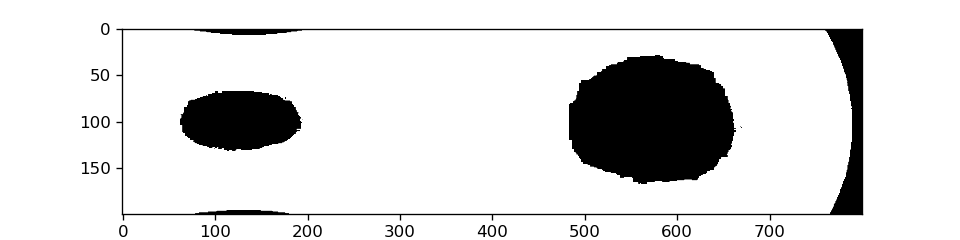

In [9]:
from ipywidgets import interact,fixed,interactive

# We'll only initialize these variables if they don't already exist
if not "grey_threshold" in globals():
    grey_threshold = 40
if not "current_frame" in globals():
    current_frame = 0

plt.ion()
fig,ax = plt.subplots(figsize = (8,2),dpi=120)
thresh_img = ax.imshow(img_list[0],cmap='gray')

def try_threshold(t_val=40,frm=0):
    global grey_threshold
    grey_threshold = t_val
    ret,thresh = cv2.threshold(img_list[frm],t_val,255,cv2.THRESH_BINARY_INV)
    thresh_img.set_data(thresh)

def get_child_widget(parent,childname):
    results = [t for t in parent.children if getattr(t, 'description', None) == childname]
    return results[0]     

def get_child_widget_value(parent,childname): # Function not used currently
    results = [t.value for t in parent.children if getattr(t, 'description', None) == childname]
    return results[0] 

def update_threshold(change):
    global grey_threshold
    grey_threshold = change['new']
    log.debug("threshold set to {}".format(change['new']))
    
def update_frame(change):
    global current_frame
    current_frame = change['new']
    log.debug("current frame set to {}".format(change['new']))

threshold_widget = interactive(try_threshold, t_val=(0,255),frm=(0,vidlen))
display(threshold_widget)

get_child_widget(threshold_widget,'t_val').observe(update_threshold, names='value')
get_child_widget(threshold_widget,'frm').observe(update_frame, names='value')

To find the width of our drop, we'll look for the top and bottom white pixels in each column.  This conviniently ignores illumination highlights on the drop that would otherwise cause trouble.

One major issue is that the leading edge of the drop will be smaller than the drop's neck for quite a while into a video.  To do this, the algorithm takes the minimum it finds and looks at the points to the left and right of it.  If one of those points doesn't contain any white pixels, it indicates that we're at the edge of the drop.  The function then drops that point from its dataset and repeats until it finds a minimum that isn't at an edge.  

**Points at the extremes of the image are also rejected, so beware this behavior if your neck is on the edge of the screen.**

Finally, the function starts at the leftmost point with the minimum radius and searches to the right until the drop widens.  It then returns a neck position that's in the middle of those points.  **This last part is not robust, it jitters a lot**

The cell below just defines our function, the one after that actually searches our video.

In [10]:
def findmin(data):
    current_data = data
    running = True
    while running:
        current_min = np.min(current_data)
        current_min_pos = np.argmax(current_data == current_min)#this finds the first point that meets the criteria
        log.debug(current_min_pos)
        if(current_min_pos >= len(current_data)-1):
            current_data = np.delete(current_data,current_min_pos)
        elif(current_data[current_min_pos-1]==ydim or current_data[current_min_pos+1]==ydim):
            current_data = np.delete(current_data,current_min_pos)
        else:
            running=False
    width=1
    while(current_data[current_min_pos+width] == current_data[current_min_pos]):
        width +=1
    return(current_min_pos + width//2)
print("Function created")

Function created


The next cell loops through our video frame by frame to find the top and bottom pixels of the drop in each column, and then find the smallest neck position.  It then overlays its estimate of the smallest neck position on top of the thresholded image.

In [18]:
neckdata = np.zeros((vidlen,xdim,3))
data_to_save = np.zeros((vidlen,5))
frames = [] 
progress = widgets.IntProgress(value=0, min=0,max=vidlen,description="Progress")
display(progress)

plt.ioff() # This keeps matplotlib from showing tons of extra figures.
for frame_val in range(0,vidlen):
    ret,thresh = cv2.threshold(img_list[frame_val],grey_threshold,255,cv2.THRESH_BINARY_INV)
    for i in range(0,xdim):
        neckdata[frame_val][i][0] = np.argmax(thresh[:,i]==255)
        neckdata[frame_val][i][1] = ydim - np.argmax(thresh[:,i][::-1]==255)
        neckdata[frame_val][i][2] = neckdata[frame_val][i][1]-neckdata[frame_val][i][0]
    
    fig,ax = plt.subplots(figsize = (10,4),dpi=120)
    ax.imshow(thresh,origin='upper', animated=True,cmap='gray');
    plt.axis([0, xdim , 0, ydim])
    
    frame_min_pos = findmin(neckdata[frame_val][:,2])
    ax.vlines(frame_min_pos,neckdata[frame_val][frame_min_pos][0],neckdata[frame_val][frame_min_pos][1],color='red')
    data_to_save[frame_val] = [frame_val,neckdata[frame_val][frame_min_pos][0],neckdata[frame_val][frame_min_pos][1],neckdata[frame_val][frame_min_pos][1] - neckdata[frame_val][frame_min_pos][0],frame_min_pos]
    frames.append(fig)
    progress.value +=1
print("Finished!")

IntProgress(value=0, description='Progress', max=125)

/var/folders/rl/tl4qtvj57b566bjy5j9py4xh0000gp/T/ipykernel_71748/34703653.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize = (10,4),dpi=120)


Finished!


Now you can scroll through the video frames to make sure nothing crazy is happening by using the widget below.  It'll take a moment to start so be patient.

In [19]:
from IPython.display import clear_output
fig, ax = plt.subplots();
disp = widgets.Output();

def showframe(frm=0):
    global frames
    disp.clear_output(wait=True);
    with disp:
        display(frames[frm]);

frame_slider2 = widgets.IntSlider(min=0,max=len(frames)-1,value=0,continuous_update=False) #I got lazy with names, so sue me.
def frame_change2(change): 
    showframe(change['new']);
    
frame_slider2.observe(frame_change2, names='value');
showframe(0);
display(disp);
display(frame_slider2);
plt.close('all')

Output()

IntSlider(value=0, continuous_update=False, max=124)

Finally, this plots our data and outputs the positions to a handy .tsv file.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
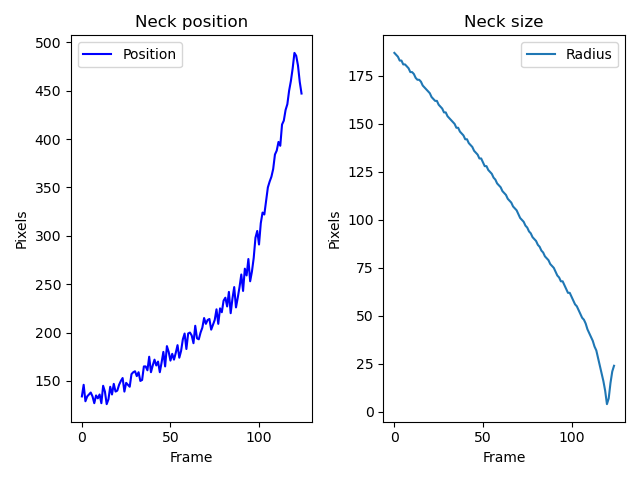

In [26]:
import time
plt.ion()
fig, (ax,ay) = plt.subplots(1,2)
scaletype = "linear"

ax.set_yscale(scaletype)
ax.set_xscale(scaletype)

ax.plot(data_to_save[::,4],label = "Position",color="b") #This plots the 5th column of the data_to_save array
ay.plot(data_to_save[::,3],label = "Radius")

ax.set_title("Neck position")
ay.set_title("Neck size")


ax.set_ylabel("Pixels")
ax.set_xlabel("Frame")

ay.set_ylabel("Pixels")
ay.set_xlabel("Frame")

plt.tight_layout()
ax.legend()
ay.legend()


dat_name = fname[:-1*fname.find(".")] + "_auto_" + str(int(time.time())) + ".tsv"# this cuts off the current suffix and adds the time
toptxt = "Video File: {}\n".format(fname)
toptxt += "Grey_threshold value: {}\n".format(grey_threshold)
toptxt += "Frame \t Radius \t Bottom \t Top \t Position"
np.savetxt(dat_name,data_to_save,header=toptxt) 

----

That was the end of the main code, the rest is for messing around or debugging.


Just for fun, we can look at the evolution of the radius along the drop over time.

Output()

IntSlider(value=0, continuous_update=False, max=124)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
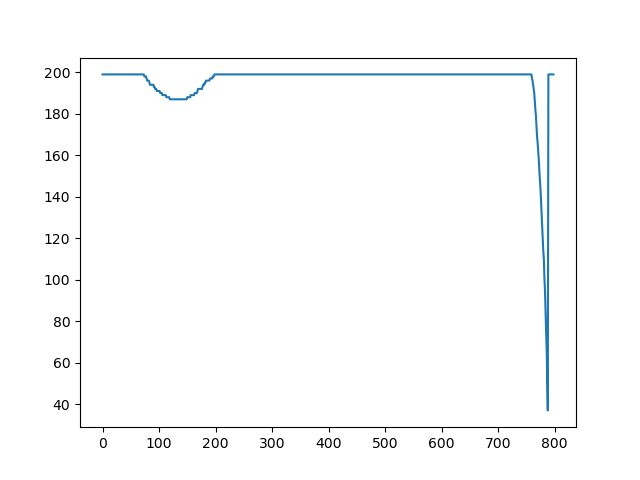

In [32]:
plt.ion()
from IPython.display import clear_output
fig, ax = plt.subplots();
disp2 = widgets.Output();

def showframe2(frm=0):
    global neckdata
    disp2.clear_output(wait=True);
    with disp2:
        plt.gca().clear()
        ax.plot(neckdata[frm][:,2]);

frame_slider3 = widgets.IntSlider(min=0,max=len(frames)-1,value=0,continuous_update=False) #I got lazy with names, so sue me.
def frame_change3(change): 
    showframe2(change['new']);

    
frame_slider3.observe(frame_change3, names='value');
showframe2(0);
display(disp2);
display(frame_slider3);

This will load the last file you saved from running an earlier cell and verify that its behaving properly.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
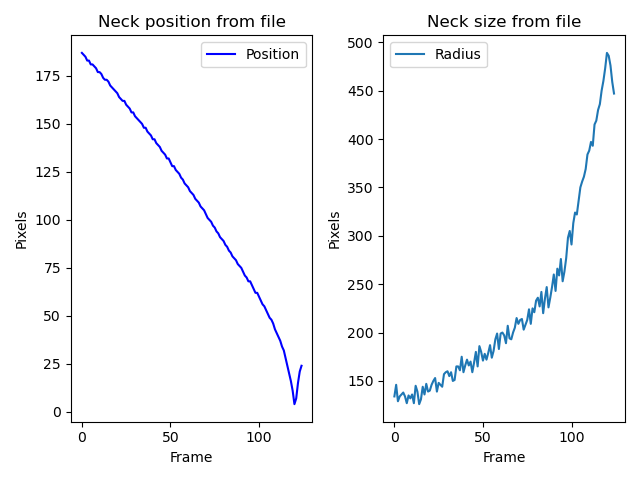

In [33]:
lframe,l_top,l_bot,l_pos,l_wid = np.loadtxt(dat_name,unpack=True)
plt.ion()
fig, (ax,ay) = plt.subplots(1,2)
scaletype = "linear"

ax.set_yscale(scaletype)
ax.set_xscale(scaletype)

ax.plot(l_pos,label = "Position",color="b") #This plots the 5th column of the data_to_save array
ay.plot(l_wid,label = "Radius")

ax.set_title("Neck position from file")
ay.set_title("Neck size from file")


ax.set_ylabel("Pixels")
ax.set_xlabel("Frame")

ay.set_ylabel("Pixels")
ay.set_xlabel("Frame")

plt.tight_layout()
ax.legend()
ay.legend()

----